# Import libraries

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(".."))

In [21]:
def generate_triplets(granularity=0.05):
    """
    Génère une liste exhaustive de triplets [p_dim, p_maint, p_aug] avec somme = 1
    """
    triplets = []
    
    # Générer tous les triplets possibles avec la granularité spécifiée
    for p_dim in np.arange(0, 1 + granularity/2, granularity):
        for p_aug in np.arange(0, 1 + granularity/2, granularity):
            p_maint = 1 - p_dim - p_aug
            # Vérifier si le triplet est valide (somme = 1 et toutes les valeurs sont ≥ 0)
            if p_maint >= -granularity/2 and abs(p_dim + p_maint + p_aug - 1) < granularity:
                # Normaliser pour garantir somme = 1 exactement
                triplet = [p_dim, max(0, p_maint), p_aug]
                if sum(triplet) > 0:  # Éviter division par zéro
                    triplet = [p/sum(triplet) for p in triplet]
                    triplets.append(triplet)
                
    return np.array(triplets)

def create_probability_space(method='grid', n_points=21, granularity=0.05):
    """
    Génère l'espace des probabilités selon la méthode choisie.
    
    Paramètres:
    -----------
    method : str
        'grid' pour une grille 2D adaptée aux visualisations
        'triplets' pour une liste de triplets adaptée à l'apprentissage
    n_points : int
        Nombre de points par dimension pour la méthode 'grid'
    granularity : float
        Granularité pour la méthode 'triplets'
        
    Retourne:
    ---------
    dict
        Contient les données selon la méthode choisie:
        - Pour 'grid': p_values, valid_mask, grid_to_triplet(i,j)
        - Pour 'triplets': triplets, triplet_to_grid_indices(t)
    """
    if method == 'grid':
        # Créer une grille 2D pour visualisation
        p_values = np.linspace(0, 1, n_points)
        valid_mask = np.zeros((n_points, n_points), dtype=bool)
        
        # Fonction pour convertir indices (i,j) vers triplet
        def grid_to_triplet(i, j):
            p_dim = p_values[i]
            p_aug = p_values[j]
            p_maint = 1 - p_dim - p_aug
            return [p_dim, p_maint, p_aug]
        
        # Initialiser le masque de validité
        for i in range(n_points):
            for j in range(n_points):
                if p_values[i] + p_values[j] <= 1:
                    valid_mask[i, j] = True
        
        return {
            'method': 'grid',
            'p_values': p_values,
            'valid_mask': valid_mask,
            'grid_to_triplet': grid_to_triplet,
            'n_points': n_points
        }
    
    elif method == 'triplets':
        # Générer une liste de triplets pour l'apprentissage
        triplets = generate_triplets(granularity)
        
        # Création d'une fonction de correspondance approximative triplet -> indices
        # Utile si on veut retrouver un triplet dans la grille
        p_values = np.linspace(0, 1, n_points)
        
        def triplet_to_grid_indices(triplet):
            p_dim, _, p_aug = triplet
            i = np.argmin(np.abs(p_values - p_dim))
            j = np.argmin(np.abs(p_values - p_aug))
            return i, j
        
        return {
            'method': 'triplets',
            'triplets': triplets,
            'triplet_to_grid_indices': triplet_to_grid_indices,
            'n_triplets': len(triplets)
        }
    
    else:
        raise ValueError("Méthode non reconnue. Utilisez 'grid' ou 'triplets'.")

# Modèle utlisateur 

In [22]:
from UserModel import UserModel

# LRI Agent

In [23]:
from LRIagent import LRIAgent

# Les expériences

## Expérience 1 : 

In [15]:
def find_elbow_point_derivative(energy_values, m_values):
    """
    Trouver le point de coude en utilisant la méthode de la dérivée seconde maximale.
    
    Args:
        energy_values: Liste des valeurs d'énergie
        m_values: Liste des valeurs du paramètre m correspondantes
    
    Returns:
        index: L'index du point de coude
    """
    # Construire d'abord la courbe Pareto comme dans la méthode de l'angle
    sorted_indices = np.argsort(energy_values)
    sorted_energy = np.array(energy_values)[sorted_indices]
    sorted_m = np.array(m_values)[sorted_indices]
    
    pareto_indices = []
    current_best_m = float('-inf')
    
    for i in range(len(sorted_energy)):
        if sorted_m[i] > current_best_m:
            pareto_indices.append(sorted_indices[i])
            current_best_m = sorted_m[i]
    
    pareto_indices = sorted(pareto_indices, key=lambda idx: energy_values[idx])
    pareto_energy = np.array([energy_values[idx] for idx in pareto_indices])
    pareto_m = np.array([m_values[idx] for idx in pareto_indices])
    
    # Calculer la dérivée première (différences)
    dy = np.diff(pareto_m)
    dx = np.diff(pareto_energy)
    derivatives = dy / (dx + 1e-10)  # +1e-10 évite division par zéro
    
    # Calculer la dérivée seconde (différence des différences)
    second_derivatives = np.abs(np.diff(derivatives))
    
    # Trouver le point avec la dérivée seconde maximale
    # +1 car nous avons perdu deux indices avec les deux opérations diff
    max_second_derivative_idx = np.argmax(second_derivatives) + 1
    
    return pareto_indices[max_second_derivative_idx]

In [43]:

def experience_1(n_executions=30, n_steps_per_execution=5000, step_size=5, max_workers=8, batch_size=10):
    """
    Version parallélisée de l'expérience 1 adaptée pour utiliser le LRIAgent et UserModel
    avec identification d'une zone de coude pour le paramètre m.
    """
    print("\n=== Expérience 1 (parallélisée avec LRIAgent): Exploration 3D de l'espace des probabilités ===")
    
    # Import nécessaires
    import numpy as np
    import os
    import time
    from concurrent.futures import ProcessPoolExecutor
    from evaluate import evaluate_triplet
    from UserModel import UserModel
    from LRIagent import LRIAgent
    import plotly.graph_objects as go
    from sklearn.cluster import KMeans
    from scipy import stats
    
    # Mesurer le temps d'exécution
    start_time = time.time()
    
    # Utiliser l'approche grille pour les visualisations 3D
    prob_space = create_probability_space(method='grid', n_points=21)
    p_values = prob_space['p_values']
    valid_mask = prob_space['valid_mask']
    grid_to_triplet = prob_space['grid_to_triplet']
    n_points = prob_space['n_points']
    
    # Préparer les tâches à paralléliser (tous les triplets valides)
    tasks = []
    
    for i in range(n_points):
        for j in range(n_points):
            if valid_mask[i, j]:
                triplet = grid_to_triplet(i, j)
                p_diminuer, p_maintenir, p_augmenter = triplet
                
                # Vérifier que le triplet est valide (tous positifs, somme = 1)
                if p_maintenir < 0 or abs(sum(triplet) - 1) > 1e-10:
                    valid_mask[i, j] = False
                    continue
                
                # Préparer les arguments pour la fonction evaluate_triplet
                task_args = (triplet, (i, j), n_executions, n_steps_per_execution, step_size)
                tasks.append(task_args)
    
    n_tasks = len(tasks)
    print(f"Évaluation parallèle de {n_tasks} triplets valides...")
    
    # Tableaux pour stocker les résultats
    energy_matrix = np.zeros((n_points, n_points))
    m_parameter_matrix = np.zeros((n_points, n_points))
    interventions_matrix = np.zeros((n_points, n_points))
    
    # Traitement par lots pour améliorer la stabilité
    for batch_start in range(0, n_tasks, batch_size):
        batch_end = min(batch_start + batch_size, n_tasks)
        current_batch = tasks[batch_start:batch_end]
        print(f"Traitement du lot {batch_start//batch_size + 1}/{(n_tasks+batch_size-1)//batch_size}: "
              f"triplets {batch_start+1}-{batch_end} sur {n_tasks}")
        
        try:
            # Exécution parallèle du lot actuel avec ProcessPoolExecutor
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                # Soumettre les tâches
                futures = [executor.submit(evaluate_triplet, task_args) for task_args in current_batch]
                
                # Collecter les résultats au fur et à mesure
                for future in futures:
                    try:
                        i, j, energy, m, interventions = future.result(timeout=300)  # Timeout de 5 minutes
                        energy_matrix[i, j] = energy
                        m_parameter_matrix[i, j] = m
                        interventions_matrix[i, j] = interventions
                    except Exception as e:
                        print(f"Erreur lors du traitement d'un triplet: {e}")
                        continue
        except Exception as e:
            print(f"Erreur lors du traitement d'un lot: {e}")
            continue
    
    # Masquer les valeurs pour les couples invalides
    energy_matrix = np.ma.masked_array(energy_matrix, ~valid_mask)
    m_parameter_matrix = np.ma.masked_array(m_parameter_matrix, ~valid_mask)
    interventions_matrix = np.ma.masked_array(interventions_matrix, ~valid_mask)
    
    # Afficher le temps écoulé
    elapsed_time = time.time() - start_time
    print(f"Temps d'exécution total: {elapsed_time:.2f} secondes")
    
    # Préparer les données pour le graphique 3D
    x_values = []
    y_values = []
    energy_values = []
    m_values = []
    interventions_values = []
    text_values = []
    valid_indices = []
    
    for i in range(n_points):
        for j in range(n_points):
            if valid_mask[i, j]:
                triplet = grid_to_triplet(i, j)
                p_dim, p_maint, p_aug = triplet
                
                x_values.append(p_dim)
                y_values.append(p_aug)
                energy_values.append(energy_matrix[i, j])
                m_values.append(m_parameter_matrix[i, j])
                interventions_values.append(interventions_matrix[i, j])
                text_values.append(f"[{p_dim:.2f}, {p_maint:.2f}, {p_aug:.2f}]<br>Énergie: {energy_matrix[i, j]:.1f}<br>M: {m_parameter_matrix[i, j]:.1f}<br>Int: {interventions_matrix[i, j]:.1f}")
                valid_indices.append((i, j))
    
    # Créer le dossier de résultats si nécessaire
    if not os.path.exists("resultats"):
        os.makedirs("resultats")
    
    # Visualisation avec Plotly
    # Figure 1: Énergie 3D
    fig1 = go.Figure(data=[go.Scatter3d(
        x=x_values, 
        y=y_values, 
        z=energy_values,
        mode='markers',
        marker=dict(
            size=6,
            color=energy_values,
            colorscale='Viridis_r',  # Inversé pour que les valeurs basses soient en vert
            colorbar=dict(title="Énergie"),
            opacity=0.8
        ),
        text=text_values,
        hovertemplate=
        '<b>p_dim</b>: %{x:.2f}<br>' +
        '<b>p_aug</b>: %{y:.2f}<br>' +
        '<b>Énergie</b>: %{z:.2f}<br>' +
        '%{text}<extra></extra>'
    )])
    
    fig1.update_layout(
        title="Énergie moyenne en fonction des probabilités p_diminuer et p_augmenter",
        scene=dict(
            xaxis_title="p(diminuer)",
            yaxis_title="p(augmenter)",
            zaxis_title="Énergie moyenne",
            xaxis=dict(range=[0, 1]),
            yaxis=dict(range=[0, 1]),
        ),
        width=900,
        height=700,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    
    # Figure 2: Paramètre m 3D
    fig2 = go.Figure(data=[go.Scatter3d(
        x=x_values, 
        y=y_values, 
        z=m_values,
        mode='markers',
        marker=dict(
            size=6,
            color=m_values,
            colorscale='Plasma',
            colorbar=dict(title="Paramètre m"),
            opacity=0.8
        ),
        text=text_values,
        hovertemplate=
        '<b>p_dim</b>: %{x:.2f}<br>' +
        '<b>p_aug</b>: %{y:.2f}<br>' +
        '<b>Paramètre m</b>: %{z:.2f}<br>' +
        '%{text}<extra></extra>'
    )])
    
    fig2.update_layout(
        title="Valeur moyenne du paramètre m en fonction des probabilités",
        scene=dict(
            xaxis_title="p(diminuer)",
            yaxis_title="p(augmenter)",
            zaxis_title="Paramètre m moyen",
            xaxis=dict(range=[0, 1]),
            yaxis=dict(range=[0, 1]),
        ),
        width=900,
        height=700,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    
    # Sauvegarder les figures
    fig1.write_html("resultats/energie_3d_lri.html")
    fig2.write_html("resultats/parametre_m_3d_lri.html")
    
    # Essayer de sauvegarder en PNG
    try:
        fig1.write_image("resultats/energie_3d_lri.png", width=900, height=700)
        fig2.write_image("resultats/parametre_m_3d_lri.png", width=900, height=700)
    except Exception as e:
        print(f"Note: Erreur lors de la sauvegarde en PNG: {e}")
        print("Les figures sont disponibles en format HTML.")
    
    # Afficher les figures
    fig1.show()
    fig2.show()
    
    # Analyser les résultats pour trouver les triplets optimaux
    
    # 1. Triplet optimal pour l'économie d'énergie (minimum)
    min_energy_idx = np.unravel_index(np.argmin(energy_matrix), energy_matrix.shape)
    min_energy_triplet = grid_to_triplet(min_energy_idx[0], min_energy_idx[1])
    
    # 2. Identification de la zone de coude pour le paramètre m (uniquement par clustering)
    # Préparer les données pour l'analyse
    data_points = np.array([[x_values[i], y_values[i], energy_values[i], m_values[i], interventions_values[i]] 
                           for i in range(len(x_values))])
    
    # Normaliser les données pour l'analyse du coude
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_points)
    
    # Utiliser K-means pour identifier les clusters
    n_clusters = 2  # Ajustable selon les données
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_scaled[:, [0, 1, 2, 3]])  # Utiliser p_dim, p_aug, énergie et m
    
    # Analyser les clusters pour trouver celui qui représente le meilleur compromis
    cluster_energy_means = [np.mean([energy_values[i] for i in range(len(clusters)) if clusters[i] == j]) 
                           for j in range(n_clusters)]
    cluster_m_means = [np.mean([m_values[i] for i in range(len(clusters)) if clusters[i] == j]) 
                      for j in range(n_clusters)]
    
    # Identifier le cluster avec un bon compromis (énergie basse et m élevé)
    # Normaliser pour la comparaison
    norm_energy = np.array(cluster_energy_means) / max(cluster_energy_means)
    norm_m = np.array(cluster_m_means) / max(cluster_m_means)
    
    # Mesure de compromis: distance au point idéal (énergie minimale, m maximal)
    compromise_scores = np.sqrt(norm_energy**2 + (1-norm_m)**2)
    best_cluster = np.argmin(compromise_scores)
    
    # Sélectionner tous les points dans ce cluster
    cluster_points = [i for i in range(len(clusters)) if clusters[i] == best_cluster]
    
    # Choisir le point le plus représentatif du cluster (point centroïde)
    # Option 1: Le point le plus proche du centre du cluster
    cluster_centroid = kmeans.cluster_centers_[best_cluster]
    # Récupérer les valeurs non normalisées du centroïde
    centroid_energy = cluster_centroid[2] * (max(energy_values) - min(energy_values)) + min(energy_values)
    centroid_m = cluster_centroid[3] * (max(m_values) - min(m_values)) + min(m_values)
    
    # Trouver le point réel le plus proche du centroïde
    distances = []
    for idx in cluster_points:
        dist = np.sqrt((energy_values[idx] - centroid_energy)**2 + (m_values[idx] - centroid_m)**2)
        distances.append((idx, dist))
    
    # Trier par distance et prendre le plus proche
    # closest_point_idx = sorted(distances, key=lambda x: x[1])[0][0]
    # elbow_i, elbow_j = valid_indices[closest_point_idx]
    # elbow_triplet = grid_to_triplet(elbow_i, elbow_j)
    
    elbow_idx = find_elbow_point_derivative(energy_values, m_values)
    elbow_i, elbow_j = valid_indices[elbow_idx]
    elbow_triplet = grid_to_triplet(elbow_i, elbow_j)
    # 3. Triplet avec le meilleur compromis (min interventions)
    min_interventions_idx = np.unravel_index(np.argmin(interventions_matrix), interventions_matrix.shape)
    min_interventions_triplet = grid_to_triplet(min_interventions_idx[0], min_interventions_idx[1])
    
    # Visualiser le point du coude et le centroïde
    # Figure 3: Visualisation du point de coude sur un graphique energie vs m
    fig3 = go.Figure()
    
    # Ajouter des couleurs différentes pour chaque cluster
    cluster_colors = ['blue', 'green', 'purple', 'orange', 'cyan']  # Ajouter plus de couleurs si besoin
    
    # Tracer tous les points colorés par cluster
    for cluster_id in range(n_clusters):
        cluster_indices = [i for i in range(len(clusters)) if clusters[i] == cluster_id]
        cluster_energy = [energy_values[i] for i in cluster_indices]
        cluster_m = [m_values[i] for i in cluster_indices]
        
        fig3.add_trace(go.Scatter(
            x=cluster_energy,
            y=cluster_m,
            mode='markers',
            marker=dict(
                size=8,
                color=cluster_colors[cluster_id % len(cluster_colors)],
                opacity=0.6
            ),
            name=f'Cluster {cluster_id+1}'
        ))
    
    # Point de coude sélectionné (le plus proche du centroïde)
    fig3.add_trace(go.Scatter(
        x=[energy_matrix[elbow_i, elbow_j]],
        y=[m_parameter_matrix[elbow_i, elbow_j]],
        mode='markers',
        marker=dict(
            size=14,
            color='red',
            symbol='star'
        ),
        name='Point de coude'
    ))
    
    fig3.update_layout(
        title="Clusters et point de coude pour le compromis énergie/confort",
        xaxis_title="Énergie moyenne",
        yaxis_title="Paramètre m moyen",
        width=800,
        height=600
    )
    
    fig3.write_html("resultats/clusters_energie_m.html")
    try:
        fig3.write_image("resultats/clusters_energie_m.png", width=800, height=600)
    except Exception:
        pass
    
    fig3.show()
    
    # Afficher les résultats
    print(f"\nConfiguration optimale pour l'énergie minimale:")
    print(f"Triplet: [{min_energy_triplet[0]:.2f}, {min_energy_triplet[1]:.2f}, {min_energy_triplet[2]:.2f}]")
    print(f"Énergie moyenne: {energy_matrix[min_energy_idx]:.2f}")
    print(f"Paramètre m: {m_parameter_matrix[min_energy_idx]:.2f}")
    print(f"Interventions: {interventions_matrix[min_energy_idx]:.2f}")
    
    print(f"\nConfiguration au point de coude (compromis énergie/confort):")
    print(f"Triplet: [{elbow_triplet[0]:.2f}, {elbow_triplet[1]:.2f}, {elbow_triplet[2]:.2f}]")
    print(f"Énergie moyenne: {energy_matrix[elbow_i, elbow_j]:.2f}")
    print(f"Paramètre m: {m_parameter_matrix[elbow_i, elbow_j]:.2f}")
    print(f"Interventions: {interventions_matrix[elbow_i, elbow_j]:.2f}")
    
    print(f"\nConfiguration optimale pour minimiser les interventions:")
    print(f"Triplet: [{min_interventions_triplet[0]:.2f}, {min_interventions_triplet[1]:.2f}, {min_interventions_triplet[2]:.2f}]")
    print(f"Énergie moyenne: {energy_matrix[min_interventions_idx]:.2f}")
    print(f"Paramètre m: {m_parameter_matrix[min_interventions_idx]:.2f}")
    print(f"Interventions: {interventions_matrix[min_interventions_idx]:.2f}")
    
    # Création d'un LRIAgent avec ces résultats
    best_triplets = [
        min_energy_triplet,
        elbow_triplet,
        min_interventions_triplet
    ]
    # Initialiser un LRIAgent avec les triplets optimaux trouvés
    lri_agent = LRIAgent(triplets=best_triplets, step_size=step_size)
    print("\nLRIAgent initialisé avec les triplets optimaux trouvés")
    
    return {
        'energy_matrix': energy_matrix, 
        'm_parameter_matrix': m_parameter_matrix, 
        'interventions_matrix': interventions_matrix,
        'best_triplets': best_triplets,
        'elbow_triplet': elbow_triplet,
        'lri_agent': lri_agent
    }

In [44]:
experience_1()


=== Expérience 1 (parallélisée avec LRIAgent): Exploration 3D de l'espace des probabilités ===
Évaluation parallèle de 218 triplets valides...
Traitement du lot 1/22: triplets 1-10 sur 218
Évaluation du triplet: p_dim=0.00, p_maint=0.95, p_aug=0.05Évaluation du triplet: p_dim=0.00, p_maint=0.70, p_aug=0.30

Évaluation du triplet: p_dim=0.00, p_maint=0.85, p_aug=0.15Évaluation du triplet: p_dim=0.00, p_maint=0.75, p_aug=0.25Évaluation du triplet: p_dim=0.00, p_maint=1.00, p_aug=0.00Évaluation du triplet: p_dim=0.00, p_maint=0.90, p_aug=0.10


Évaluation du triplet: p_dim=0.00, p_maint=0.80, p_aug=0.20

Évaluation du triplet: p_dim=0.00, p_maint=0.65, p_aug=0.35
Évaluation du triplet: p_dim=0.00, p_maint=0.60, p_aug=0.40
Évaluation du triplet: p_dim=0.00, p_maint=0.55, p_aug=0.45
Traitement du lot 2/22: triplets 11-20 sur 218
Évaluation du triplet: p_dim=0.00, p_maint=0.50, p_aug=0.50
Évaluation du triplet: p_dim=0.00, p_maint=0.45, p_aug=0.55
Évaluation du triplet: p_dim=0.00, p_maint=


Configuration optimale pour l'énergie minimale:
Triplet: [0.75, 0.00, 0.25]
Énergie moyenne: 64.32
Paramètre m: 36.44
Interventions: 256.17

Configuration au point de coude (compromis énergie/confort):
Triplet: [0.75, 0.10, 0.15]
Énergie moyenne: 64.52
Paramètre m: 36.66
Interventions: 292.27

Configuration optimale pour minimiser les interventions:
Triplet: [0.00, 1.00, 0.00]
Énergie moyenne: 90.00
Paramètre m: 35.00
Interventions: 0.00
Agent initialisé avec 3 triplets de probabilités

LRIAgent initialisé avec les triplets optimaux trouvés


{'energy_matrix': masked_array(
   data=[[90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0,
          90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0,
          90.0],
         [64.72661666666666, 70.14935, 79.84338333333334,
          82.31003333333334, 83.07533333333336, 83.42371666666666,
          83.70338333333332, 83.82051666666665, 83.90541666666668,
          83.95160000000001, 83.98896666666666, 84.0157166666667,
          83.98826666666668, 83.9692, 83.91049999999997,
          83.81356666666666, 83.66711666666667, 83.44133333333333,
          83.04621666666667, --, --],
         [65.09223333333334, 65.63153333333334, 70.31161666666667,
          76.27888333333334, 79.55351666666665, 81.10611666666667,
          81.85098333333333, 82.29343333333334, 82.65598333333335,
          82.80805000000001, 82.90501666666665, 82.95905000000002,
          82.97990000000001, 82.97033333333334, 82.90974999999999,
          82.81873333333333, 82.63404999999999, 82.31460

## Exéprience 2 : 

In [ ]:
def experience_2(n_executions=20, n_steps_per_execution=50000, step_size=5, gamma=0.45, 
                 granularity=0.05, max_workers=6, batch_size=5):
    """
    Version optimisée pour réduire la charge thermique tout en maintenant des performances raisonnables.
    Utilise la fonction calculate_reward de la classe LRIAgent pour le calcul des récompenses.
    """
    print(f"\n=== Expérience 2 (optimisée thermiquement): Évaluation des triplets (granularité={granularity}) ===")
    
    # Import nécessaires
    from concurrent.futures import ProcessPoolExecutor, as_completed
    import time
    import multiprocessing
    import psutil
    from evaluate import evaluate_triplet_exp2
    import plotly.graph_objects as go
    import pandas as pd
    from LRIagent import LRIAgent
    
    # Configuration optimisée pour réduire la charge thermique
    if max_workers is None:
        # Limiter à 50-60% des cœurs disponibles pour éviter la surchauffe
        max_workers = multiprocessing.cpu_count() - 2
    
    print(f"Utilisation de {max_workers} processus pour la parallélisation")
    
    # Mesurer le temps d'exécution
    start_time = time.time()
    
    # Utiliser l'approche grid pour la visualisation 3D
    n_points = 21
    prob_space_grid = create_probability_space(method='grid', n_points=n_points)
    valid_mask = prob_space_grid['valid_mask']
    grid_to_triplet = prob_space_grid['grid_to_triplet']
    
    # Utiliser l'approche triplets pour l'évaluation exhaustive
    prob_space = create_probability_space(method='triplets', granularity=granularity)
    triplets = prob_space['triplets']
    n_triplets = prob_space['n_triplets']
    
    print(f"Évaluation de {n_triplets} triplets distincts avec optimisation thermique")
    
    # Tableaux pour stocker les résultats
    rewards = np.zeros(n_triplets)
    energy_values = np.zeros(n_triplets)
    m_values = np.zeros(n_triplets)
    
    # Création d'un agent LRI de référence pour utiliser sa fonction de calcul de récompense
    lri_reference = LRIAgent(triplets=[triplets[0]], step_size=step_size, gamma=gamma)
    
    # Préparer les tâches à paralléliser
    tasks = []
    for t_idx, triplet in enumerate(triplets):
        task_args = (triplet, t_idx, n_executions, n_steps_per_execution, step_size, gamma)
        tasks.append(task_args)
    
    # Traitement par lots plus petits pour réduire la charge
    for batch_start in range(0, n_triplets, batch_size):
        batch_end = min(batch_start + batch_size, n_triplets)
        current_batch = tasks[batch_start:batch_end]
        print(f"Traitement du lot {batch_start//batch_size + 1}/{(n_triplets+batch_size-1)//batch_size}: "
              f"triplets {batch_start+1}-{batch_end} sur {n_triplets}")
        
        # Vérifier l'utilisation CPU et la température si possible
        try:
            cpu_percent = psutil.cpu_percent(interval=0.5)
            print(f"Utilisation CPU actuelle: {cpu_percent}%")
        except:
            pass
        
        # Liste pour stocker les résultats du lot
        batch_results = []
        
        try:
            # Exécution parallèle du lot actuel avec meilleure gestion
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                # Soumettre les tâches et récupérer les futures
                future_to_task = {executor.submit(evaluate_triplet_exp2, task_args): task_args 
                                 for task_args in current_batch}
                
                # Collecter les résultats au fur et à mesure qu'ils sont terminés
                for future in as_completed(future_to_task, timeout=600):  # 10 min timeout
                    try:
                        result = future.result()
                        batch_results.append(result)
                        # Afficher progression
                        if len(batch_results) % max(1, max_workers//2) == 0:
                            print(f"  Progression: {len(batch_results)}/{len(current_batch)} triplets traités")
                    except Exception as e:
                        task = future_to_task[future]
                        print(f"Erreur pour le triplet {task[0]}: {e}")
            
            # Traiter tous les résultats du lot après la fin de l'exécution parallèle
            for result in batch_results:
                t_idx, reward, energy, m_value = result
                rewards[t_idx] = reward
                energy_values[t_idx] = energy
                m_values[t_idx] = m_value
                
            # # Pause de refroidissement entre les lots
            # print("Pause de 2 secondes pour permettre le refroidissement...")
            # time.sleep(2)
                
        except Exception as e:
            print(f"Erreur lors du traitement du lot: {e}")
            continue
    
    # Afficher le temps écoulé
    elapsed_time = time.time() - start_time
    print(f"Temps d'exécution total: {elapsed_time:.2f} secondes")
    
    # Trouver le meilleur triplet
    best_idx = np.argmax(rewards)
    best_triplet = triplets[best_idx]
    
    # Remplir les matrices pour la visualisation 3D
    reward_matrix = np.zeros((n_points, n_points))
    energy_matrix = np.zeros((n_points, n_points))
    m_matrix = np.zeros((n_points, n_points))
    
    for i in range(n_points):
        for j in range(n_points):
            if valid_mask[i, j]:
                grid_triplet = grid_to_triplet(i, j)
                # Trouver le triplet le plus proche parmi ceux évalués
                dists = np.sum((triplets - grid_triplet)**2, axis=1)
                closest_idx = np.argmin(dists)
                reward_matrix[i, j] = rewards[closest_idx]
                energy_matrix[i, j] = energy_values[closest_idx]
                m_matrix[i, j] = m_values[closest_idx]
    
    # Masquer les valeurs pour les couples invalides
    reward_matrix = np.ma.masked_array(reward_matrix, ~valid_mask)
    energy_matrix = np.ma.masked_array(energy_matrix, ~valid_mask)
    m_matrix = np.ma.masked_array(m_matrix, ~valid_mask)
    
    print(f"\nMeilleur triplet: [{best_triplet[0]:.2f}, {best_triplet[1]:.2f}, {best_triplet[2]:.2f}]")
    print(f"Récompense maximale: {rewards[best_idx]:.4f}")
    print(f"Énergie moyenne: {energy_values[best_idx]:.2f}")
    print(f"Valeur m moyenne: {m_values[best_idx]:.2f}")
    
    # Obtenir les top 20 triplets
    sorted_indices = np.argsort(rewards)[::-1][:20]
    top_triplets = triplets[sorted_indices]
    top_rewards = rewards[sorted_indices]
    top_energy = energy_values[sorted_indices]
    top_m = m_values[sorted_indices]
    
    # Créer un dataframe pour une visualisation plus claire
    df = pd.DataFrame({
        'Diminuer': top_triplets[:, 0],
        'Maintenir': top_triplets[:, 1],
        'Augmenter': top_triplets[:, 2],
        'Récompense': top_rewards,
        'Énergie': top_energy,
        'Paramètre m': top_m
    })
    
    print("\nTop 5 triplets:")
    print(df[:5].to_string(index=False, float_format=lambda x: f"{x:.3f}"))
    
    # Préparer les données pour les graphiques 3D
    x_values = []
    y_values = []
    reward_values = []
    energy_values_graph = []
    m_values_graph = []
    text_values = []
    
    for i in range(n_points):
        for j in range(n_points):
            if valid_mask[i, j]:
                triplet = grid_to_triplet(i, j)
                p_dim, p_maint, p_aug = triplet
                
                x_values.append(p_dim)
                y_values.append(p_aug)
                reward_values.append(reward_matrix[i, j])
                energy_values_graph.append(energy_matrix[i, j])
                m_values_graph.append(m_matrix[i, j])
                text_values.append(f"[{p_dim:.2f}, {p_maint:.2f}, {p_aug:.2f}]<br>"
                                  f"Récompense: {reward_matrix[i, j]:.3f}<br>"
                                  f"Énergie: {energy_matrix[i, j]:.2f}<br>"
                                  f"Paramètre m: {m_matrix[i, j]:.2f}")
    
    # Figure 1: Récompense 3D avec Plotly
    fig1 = go.Figure(data=[go.Scatter3d(
        x=x_values, 
        y=y_values, 
        z=reward_values,
        mode='markers',
        marker=dict(
            size=6,
            color=reward_values,
            colorscale='Viridis',
            colorbar=dict(title="Récompense"),
            opacity=0.8
        ),
        text=text_values,
        hovertemplate=
        '<b>p_dim</b>: %{x:.2f}<br>' +
        '<b>p_aug</b>: %{y:.2f}<br>' +
        '<b>Récompense</b>: %{z:.3f}<br>' +
        '%{text}<extra></extra>'
    )])
    
    # Ajouter un point spécial pour marquer le meilleur triplet
    fig1.add_trace(go.Scatter3d(
        x=[best_triplet[0]],
        y=[best_triplet[2]],  # p_aug est stocké en position 2
        z=[rewards[best_idx]],
        mode='markers',
        marker=dict(
            size=12,
            color='red',
            symbol='diamond',
            line=dict(color='black', width=1)
        ),
        name="Meilleur triplet",
        text=[f"Optimal: [{best_triplet[0]:.2f}, {best_triplet[1]:.2f}, {best_triplet[2]:.2f}]<br>Récompense: {rewards[best_idx]:.3f}"],
        hovertemplate='%{text}<extra></extra>'
    ))
    
    fig1.update_layout(
        title="Récompense mixte en fonction des probabilités p_diminuer et p_augmenter",
        scene=dict(
            xaxis_title="p(diminuer)",
            yaxis_title="p(augmenter)",
            zaxis_title="Récompense mixte",
            xaxis=dict(range=[0, 1]),
            yaxis=dict(range=[0, 1]),
        ),
        width=900,
        height=700,
        margin=dict(l=0, r=0, b=0, t=50)
    )
    
    # Figure 2: Visualisation des meilleurs triplets (énergie vs m)
    fig2 = go.Figure()
    
    # Tracer les meilleurs points (top 20)
    fig2.add_trace(go.Scatter(
        x=top_energy,
        y=top_m,
        mode='markers',
        marker=dict(
            size=10,
            color=top_rewards,
            colorscale='Viridis',
            colorbar=dict(title="Récompense"),
            showscale=True
        ),
        text=[f"Triplet: [{t[0]:.2f}, {t[1]:.2f}, {t[2]:.2f}]<br>"
              f"Récompense: {r:.3f}<br>"
              f"Énergie: {e:.2f}<br>"
              f"Paramètre m: {m:.2f}"
              for t, r, e, m in zip(top_triplets, top_rewards, top_energy, top_m)],
        hovertemplate='%{text}<extra></extra>',
        name='Top 20 triplets'
    ))
    
    # Ajouter le meilleur triplet
    fig2.add_trace(go.Scatter(
        x=[energy_values[best_idx]],
        y=[m_values[best_idx]],
        mode='markers',
        marker=dict(
            size=14,
            color='red',
            symbol='star'
        ),
        name='Meilleur triplet',
        text=[f"Optimal: [{best_triplet[0]:.2f}, {best_triplet[1]:.2f}, {best_triplet[2]:.2f}]<br>"
              f"Récompense: {rewards[best_idx]:.3f}"],
        hovertemplate='%{text}<extra></extra>'
    ))
    
    fig2.update_layout(
        title="Compromis énergie-confort pour les meilleurs triplets",
        xaxis_title="Énergie moyenne",
        yaxis_title="Paramètre m moyen",
        width=800,
        height=600,
        margin=dict(l=50, r=50, b=50, t=50)
    )
    
    # Sauvegarder les figures
    if not os.path.exists("resultats"):
        os.makedirs("resultats")
        
    fig1.write_html("resultats/recompense_mixte_3d.html")
    fig2.write_html("resultats/top_triplets_energie_m.html")
    
    # Sauvegarder en PNG
    
    fig1.write_image("resultats/recompense_mixte_3d.png", width=900, height=700)
    fig2.write_image("resultats/top_triplets_energie_m.png", width=800, height=600)
    print("Note: La sauvegarde en PNG a été effectuée.")
    
    # Afficher les figures
    fig1.show()
    fig2.show()
    
    # Création d'un LRIAgent avec le meilleur triplet
    lri_agent = LRIAgent(triplets=[best_triplet], step_size=step_size, gamma=gamma)
    print("\nLRIAgent initialisé avec le meilleur triplet")
    
    return {
        'triplets': triplets, 
        'rewards': rewards, 
        'energy_values': energy_values,
        'm_values': m_values,
        'best_triplet': best_triplet,
        'top_triplets': top_triplets[:10],
        'lri_agent': lri_agent
    }

In [ ]:
experience_2(n_executions=20, n_steps_per_execution=20000, step_size=5, gamma=0.45, 
                 granularity=0.05, max_workers=6, batch_size=5)


=== Expérience 2 (optimisée thermiquement): Évaluation des triplets (granularité=0.05) ===
Utilisation de 6 processus pour la parallélisation
Évaluation de 231 triplets distincts avec optimisation thermique
Agent initialisé avec 1 triplets de probabilités
Traitement du lot 1/47: triplets 1-5 sur 231
Utilisation CPU actuelle: 19.6%
Évaluation du triplet 4: [0.00, 0.85, 0.15]Évaluation du triplet 3: [0.00, 0.90, 0.10]

Évaluation du triplet 1: [0.00, 1.00, 0.00]
Évaluation du triplet 5: [0.00, 0.80, 0.20]
Évaluation du triplet 2: [0.00, 0.95, 0.05]
  Progression: 3/5 triplets traités
Traitement du lot 2/47: triplets 6-10 sur 231
Utilisation CPU actuelle: 15.2%
Évaluation du triplet 6: [0.00, 0.75, 0.25]
Évaluation du triplet 7: [0.00, 0.70, 0.30]
Évaluation du triplet 8: [0.00, 0.65, 0.35]
Évaluation du triplet 9: [0.00, 0.60, 0.40]
Évaluation du triplet 10: [0.00, 0.55, 0.45]
  Progression: 3/5 triplets traités
Traitement du lot 3/47: triplets 11-15 sur 231
Utilisation CPU actuelle: 18

Agent initialisé avec 1 triplets de probabilités

LRIAgent initialisé avec le meilleur triplet


{'triplets': array([[0.  , 1.  , 0.  ],
        [0.  , 0.95, 0.05],
        [0.  , 0.9 , 0.1 ],
        [0.  , 0.85, 0.15],
        [0.  , 0.8 , 0.2 ],
        [0.  , 0.75, 0.25],
        [0.  , 0.7 , 0.3 ],
        [0.  , 0.65, 0.35],
        [0.  , 0.6 , 0.4 ],
        [0.  , 0.55, 0.45],
        [0.  , 0.5 , 0.5 ],
        [0.  , 0.45, 0.55],
        [0.  , 0.4 , 0.6 ],
        [0.  , 0.35, 0.65],
        [0.  , 0.3 , 0.7 ],
        [0.  , 0.25, 0.75],
        [0.  , 0.2 , 0.8 ],
        [0.  , 0.15, 0.85],
        [0.  , 0.1 , 0.9 ],
        [0.  , 0.05, 0.95],
        [0.  , 0.  , 1.  ],
        [0.05, 0.95, 0.  ],
        [0.05, 0.9 , 0.05],
        [0.05, 0.85, 0.1 ],
        [0.05, 0.8 , 0.15],
        [0.05, 0.75, 0.2 ],
        [0.05, 0.7 , 0.25],
        [0.05, 0.65, 0.3 ],
        [0.05, 0.6 , 0.35],
        [0.05, 0.55, 0.4 ],
        [0.05, 0.5 , 0.45],
        [0.05, 0.45, 0.5 ],
        [0.05, 0.4 , 0.55],
        [0.05, 0.35, 0.6 ],
        [0.05, 0.3 , 0.65],
        

## Expérience 3 : 

In [ ]:
def experience_3(n_steps=1000000, granularity=0.05, alpha=0.0005, gamma=0.45, 
                            step_size=5, pre=0.35, period_length=10000, n_runs=50):
    """
    Expérience 3: Convergence vers un triplet optimal par apprentissage.
    """
    print(f"\n=== Expérience 3: Convergence vers un triplet optimal (granularité={granularity}) ===")
    
    # Import de la fonction trapezoid pour calculer l'énergie comme l'aire sous la courbe
    from numpy import trapezoid
    from LRIagent import LRIAgent
    # Utiliser l'approche triplets pour l'apprentissage
    prob_space = create_probability_space(method='triplets', granularity=granularity)
    triplets = prob_space['triplets']
    n_triplets = prob_space['n_triplets']
    
    print(f"Utilisation de {n_triplets} triplets prédéfinis")
    
    # Nombre de périodes
    n_periods = n_steps // period_length
    
    # Stockage des résultats
    all_best_triplets = []
    all_energy_values = np.zeros((n_runs, n_periods))
    all_m_values = np.zeros((n_runs, n_periods))
    all_intervention_counts = np.zeros((n_runs, n_periods))
    
    # Exécution des simulations
    for run in range(n_runs):
        print(f"Exécution {run+1}/{n_runs}...")
        
        # Initialisation
        agent = LRIAgent(triplets=triplets, step_size=step_size, alpha=alpha, gamma=gamma)
        user = UserModel(s_min=0, s_max=90, a0=0.2, m0=35, pre=pre)
        
        # Variables pour la simulation
        current_signal = 90
        energy_history = []
        m_history = []
        intervention_history = []
        best_triplet_history = []
        
        # Variables pour les statistiques par période
        period_energy = []
        period_m = []
        period_interventions = 0
        
        # Simulation
        for step in range(n_steps):
            # Sélectionner une action selon le meilleur triplet actuel
            new_signal = agent.select_action(current_signal)
            
            # Valeur avant intervention
            old_value = current_signal
            
            # Appliquer l'action via le modèle utilisateur
            signal_value = user.update_parameters_with_value(new_signal)
            
            # Collecter des données
            energy_history.append(signal_value)
            m_history.append(user.m)
            period_energy.append(signal_value)
            period_m.append(user.m)
            
            # Durée et temps sans intervention pour calculer la récompense
            duration = 1
            idle_time = 1
            
            # Vérifier s'il y a eu intervention
            if signal_value == user.s_max and old_value != user.s_max:
                # Intervention: réinitialiser le signal et compter l'intervention
                current_signal = 90
                period_interventions += 1
                idle_time = 0
            else:
                # Pas d'intervention: mettre à jour le signal courant
                current_signal = new_signal
            
            # Calculer la récompense
            reward = agent.calculate_reward(signal_value, duration, idle_time)
            
            # Mise à jour de l'agent
            agent.update(reward)
            
            # Enregistrer le meilleur triplet actuel
            best_triplet = agent.get_best_triplet()
            best_triplet_history.append(best_triplet)
            
            # Fin d'une période?
            if (step + 1) % period_length == 0:
                period = step // period_length
                
                # Calculer l'énergie comme l'aire sous la courbe et normaliser par la durée
                if len(period_energy) > 0:
                    # Utiliser trapezoid pour obtenir une meilleure estimation de l'énergie totale
                    total_energy = trapezoid(period_energy) / len(period_energy)
                    all_energy_values[run, period] = total_energy
                else:
                    all_energy_values[run, period] = 0
                
                # Enregistrer les autres statistiques pour cette période
                all_m_values[run, period] = np.mean(period_m) if period_m else 0
                all_intervention_counts[run, period] = period_interventions
                
                # Réinitialiser pour la période suivante
                period_energy = []
                period_m = []
                period_interventions = 0
        
        # Enregistrer le meilleur triplet final
        all_best_triplets.append(agent.get_best_triplet())
    
    # Calcul des moyennes sur toutes les exécutions
    mean_energy = np.mean(all_energy_values, axis=0)
    mean_m = np.mean(all_m_values, axis=0)
    mean_interventions = np.mean(all_intervention_counts, axis=0)
    
    # Meilleur triplet moyen
    best_triplet_mean = np.mean(all_best_triplets, axis=0)
    
    # Créer des figures améliorées
    plt.figure(figsize=(18, 12))
    
    # Palette de couleurs personnalisée
    colors = ['#3366CC', '#33CC99', '#CC6633', '#CC0033']
    
    # 1. Évolution de l'énergie avec visualisation améliorée
    ax1 = plt.subplot(2, 2, 1)
    # Tracer l'évolution de l'énergie avec une ligne plus épaisse
    line_energy, = ax1.plot(mean_energy, linewidth=2.5, color=colors[0])
    
    # Ajouter une zone ombrée pour montrer la tendance
    window_size = min(10, len(mean_energy) // 5)
    if window_size > 0:
        smoothed_energy = np.convolve(mean_energy, np.ones(window_size)/window_size, mode='valid')
        padding = len(mean_energy) - len(smoothed_energy)
        ax1.fill_between(
            range(padding, len(mean_energy)), 
            smoothed_energy, 
            mean_energy[padding:], 
            alpha=0.3, 
            color=colors[0]
        )
    
    # Ajouter une ligne horizontale pour la valeur finale
    ax1.axhline(y=mean_energy[-1], color='red', linestyle='--', alpha=0.7, 
                label=f'Valeur finale: {mean_energy[-1]:.2f}')
    
    ax1.set_xlabel(f"Période (x{period_length} pas)", fontsize=12)
    ax1.set_ylabel("Énergie moyenne", fontsize=12)
    ax1.set_title("(a) Évolution de la consommation d'énergie", fontsize=14, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10)
    
    # 2. Évolution du seuil d'intervention (m) avec visualisation améliorée
    ax2 = plt.subplot(2, 2, 2)
    line_m, = ax2.plot(mean_m, linewidth=2.5, color=colors[1])
    
    # Ajouter les écarts-types comme zones ombrées
    if n_runs > 1:
        std_m = np.std(all_m_values, axis=0)
        ax2.fill_between(
            range(len(mean_m)), 
            mean_m - std_m, 
            mean_m + std_m, 
            alpha=0.3, 
            color=colors[1],
            label=f'Écart-type'
        )
    
    # Ajouter une ligne horizontale pour la valeur finale
    ax2.axhline(y=mean_m[-1], color='red', linestyle='--', alpha=0.7, 
                label=f'Valeur finale: {mean_m[-1]:.2f}')
    
    ax2.set_xlabel(f"Période (x{period_length} pas)", fontsize=12)
    ax2.set_ylabel("Valeur m moyenne", fontsize=12)
    ax2.set_title("(b) Évolution du seuil d'intervention", fontsize=14, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=10)
    
    # 3. Évolution des interventions avec visualisation améliorée
    ax3 = plt.subplot(2, 2, 3)
    line_interventions, = ax3.plot(mean_interventions, linewidth=2.5, color=colors[2])
    
    # Ajouter un graphique en barres pour mieux visualiser
    ax3.bar(range(len(mean_interventions)), mean_interventions, alpha=0.3, color=colors[2])
    
    ax3.set_xlabel(f"Période (x{period_length} pas)", fontsize=12)
    ax3.set_ylabel("Nombre d'interventions", fontsize=12)
    ax3.set_title("(c) Évolution des interventions utilisateur", fontsize=14, fontweight='bold')
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # 4. Visualisation des triplets finaux améliorée
    ax4 = plt.subplot(2, 2, 4)
    triplet_names = ['Diminuer', 'Maintenir', 'Augmenter']
    x = np.arange(len(triplet_names))
    width = 0.7 / (n_runs + 1)  # Ajuster la largeur en fonction du nombre d'exécutions
    
    # Tracer chaque exécution avec transparence croissante
    for i, triplet in enumerate(all_best_triplets):
        # Calculer l'opacité en fonction de l'indice (les derniers runs sont plus opaques)
        alpha_value = 0.4 + 0.5 * (i / n_runs)
        ax4.bar(x + (i - n_runs/2) * width, triplet, width, alpha=alpha_value, 
                label=f"Run {i+1}", edgecolor='black', linewidth=0.5)
    
    # Triplet moyen avec couleur distincte
    ax4.bar(x, best_triplet_mean, width*1.5, color='red', label="Moyenne", 
            alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Améliorer la légende et les étiquettes
    for i, value in enumerate(best_triplet_mean):
        ax4.text(i, value + 0.02, f"{value:.2f}", ha='center', va='bottom', 
                fontweight='bold', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="gray", alpha=0.7))
    
    ax4.set_xticks(x)
    ax4.set_xticklabels(triplet_names, fontsize=12)
    ax4.set_ylabel("Probabilité", fontsize=12)
    ax4.set_title("(d) Triplets optimaux par exécution", fontsize=14, fontweight='bold')
    ax4.set_ylim(0, 1.1)
    ax4.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Placer la légende en dehors du graphique
    handles, labels = ax4.get_legend_handles_labels()
    ax4.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
               ncol=min(5, n_runs+1), fontsize=10)
    
    plt.tight_layout()
    
    # Sauvegarder et afficher
    if not os.path.exists("resultats"):
        os.makedirs("resultats")
    plt.savefig("resultats/evolution_triplets_optimo.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Afficher les résultats
    print("\nMeilleurs triplets finaux:")
    for i, triplet in enumerate(all_best_triplets):
        print(f"Run {i+1}: [{triplet[0]:.2f}, {triplet[1]:.2f}, {triplet[2]:.2f}]")
    
    print(f"\nTriplet moyen: [{best_triplet_mean[0]:.2f}, {best_triplet_mean[1]:.2f}, {best_triplet_mean[2]:.2f}]")
    
    # Visualisation supplémentaire pour le triplet moyen (en barres horizontales)
    plt.figure(figsize=(10, 5))
    
    # Barres horizontales pour mieux visualiser le triplet final
    bars = plt.barh(triplet_names, best_triplet_mean, color=colors[:3], alpha=0.8, 
                   edgecolor='black', linewidth=1)
    
    # Ajouter les valeurs à droite des barres
    for bar, value in zip(bars, best_triplet_mean):
        plt.text(value + 0.02, bar.get_y() + bar.get_height()/2, f"{value:.3f}", 
                 va='center', fontweight='bold')
    
    plt.xlim(0, 1.1)
    plt.title("Triplet de probabilités optimal (moyenne des exécutions)", fontsize=14, fontweight='bold')
    plt.xlabel("Probabilité", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("resultats/triplet_optimal_final.png", dpi=300)
    plt.show()
    
    return all_best_triplets, mean_energy, mean_m, mean_interventions


=== Expérience 3: Convergence vers un triplet optimal (granularité=0.05) ===
Utilisation de 231 triplets prédéfinis
Exécution 1/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 2/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 3/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 4/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 5/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 6/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 7/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 8/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 9/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 10/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 11/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 12/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 13/100...
Agent initialisé ave

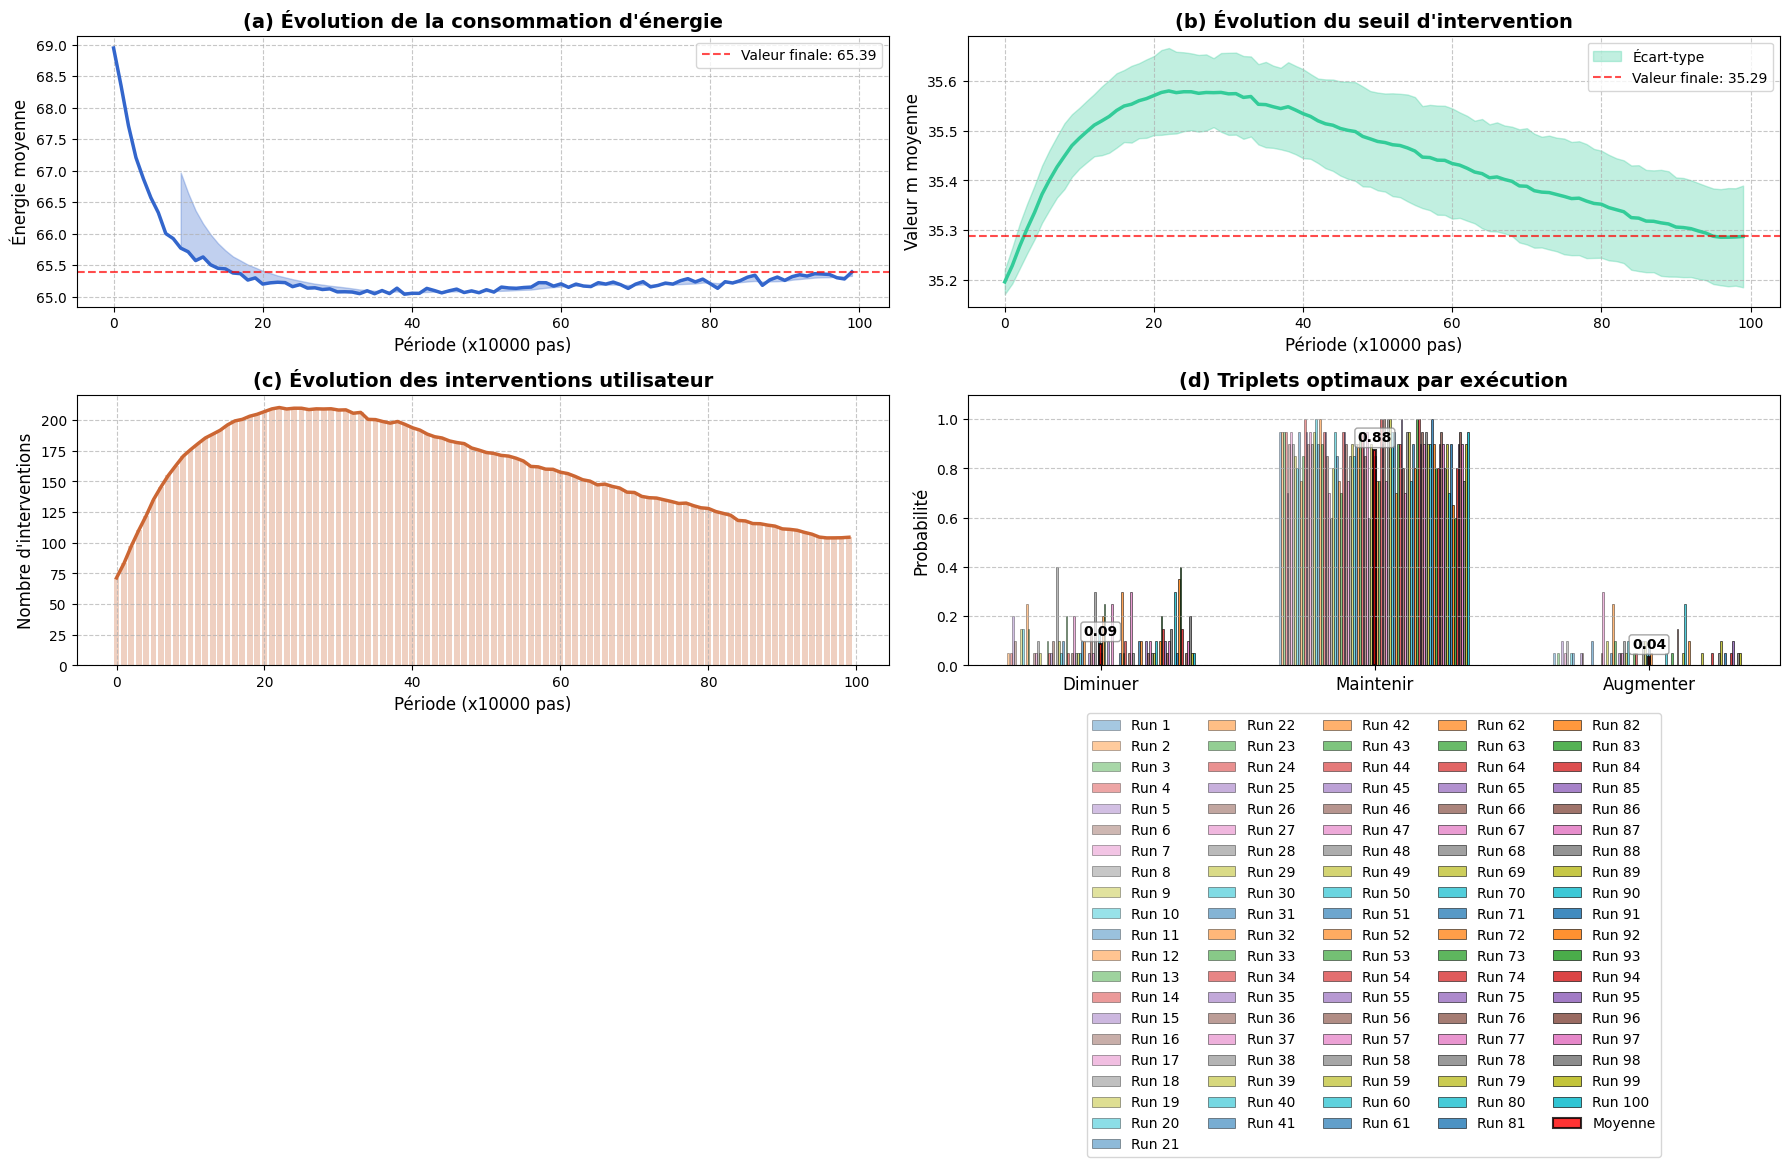


Meilleurs triplets finaux:
Run 1: [0.00, 0.95, 0.05]
Run 2: [0.05, 0.95, 0.00]
Run 3: [0.00, 0.95, 0.05]
Run 4: [0.05, 0.95, 0.00]
Run 5: [0.20, 0.70, 0.10]
Run 6: [0.10, 0.90, 0.00]
Run 7: [0.00, 0.95, 0.05]
Run 8: [0.00, 0.90, 0.10]
Run 9: [0.15, 0.85, 0.00]
Run 10: [0.15, 0.80, 0.05]
Run 11: [0.00, 0.95, 0.05]
Run 12: [0.25, 0.75, 0.00]
Run 13: [0.15, 0.85, 0.00]
Run 14: [0.00, 1.00, 0.00]
Run 15: [0.00, 0.95, 0.05]
Run 16: [0.05, 0.90, 0.05]
Run 17: [0.05, 0.95, 0.00]
Run 18: [0.10, 0.90, 0.00]
Run 19: [0.05, 0.95, 0.00]
Run 20: [0.00, 1.00, 0.00]
Run 21: [0.00, 0.90, 0.10]
Run 22: [0.00, 1.00, 0.00]
Run 23: [0.10, 0.90, 0.00]
Run 24: [0.05, 0.95, 0.00]
Run 25: [0.05, 0.95, 0.00]
Run 26: [0.10, 0.85, 0.05]
Run 27: [0.00, 0.70, 0.30]
Run 28: [0.40, 0.60, 0.00]
Run 29: [0.10, 0.80, 0.10]
Run 30: [0.05, 0.95, 0.00]
Run 31: [0.10, 0.85, 0.05]
Run 32: [0.00, 0.75, 0.25]
Run 33: [0.20, 0.70, 0.10]
Run 34: [0.05, 0.95, 0.00]
Run 35: [0.00, 0.95, 0.05]
Run 36: [0.05, 0.90, 0.05]
Run 37: [

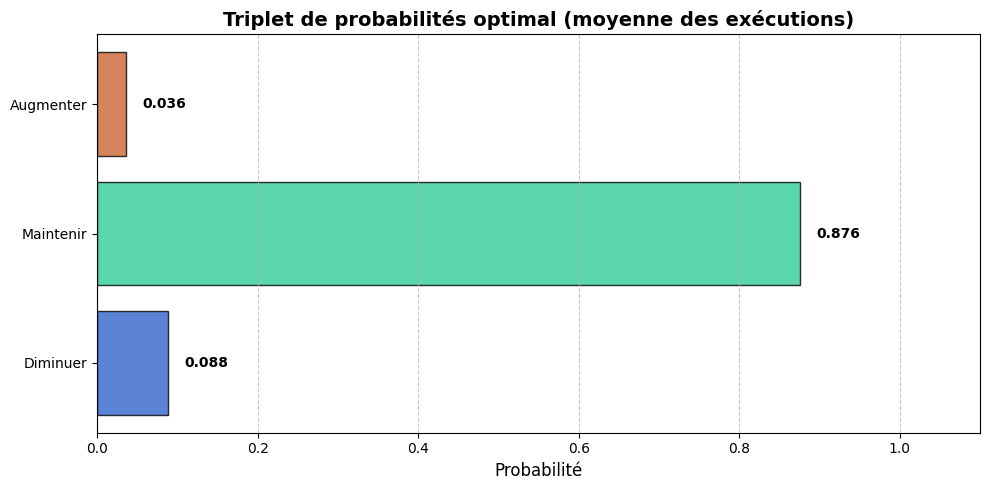

([array([0.  , 0.95, 0.05]),
  array([0.05, 0.95, 0.  ]),
  array([0.  , 0.95, 0.05]),
  array([0.05, 0.95, 0.  ]),
  array([0.2, 0.7, 0.1]),
  array([0.1, 0.9, 0. ]),
  array([0.  , 0.95, 0.05]),
  array([0. , 0.9, 0.1]),
  array([0.15, 0.85, 0.  ]),
  array([0.15, 0.8 , 0.05]),
  array([0.  , 0.95, 0.05]),
  array([0.25, 0.75, 0.  ]),
  array([0.15, 0.85, 0.  ]),
  array([0., 1., 0.]),
  array([0.  , 0.95, 0.05]),
  array([0.05, 0.9 , 0.05]),
  array([0.05, 0.95, 0.  ]),
  array([0.1, 0.9, 0. ]),
  array([0.05, 0.95, 0.  ]),
  array([0., 1., 0.]),
  array([0. , 0.9, 0.1]),
  array([0., 1., 0.]),
  array([0.1, 0.9, 0. ]),
  array([0.05, 0.95, 0.  ]),
  array([0.05, 0.95, 0.  ]),
  array([0.1 , 0.85, 0.05]),
  array([0. , 0.7, 0.3]),
  array([0.4, 0.6, 0. ]),
  array([0.1, 0.8, 0.1]),
  array([0.05, 0.95, 0.  ]),
  array([0.1 , 0.85, 0.05]),
  array([0.  , 0.75, 0.25]),
  array([0.2, 0.7, 0.1]),
  array([0.05, 0.95, 0.  ]),
  array([0.  , 0.95, 0.05]),
  array([0.05, 0.9 , 0.05]),
  ar

In [17]:
experience_3(n_runs=100, n_steps=1000000, granularity=0.05, alpha=0.0005, gamma=0.45, 
             step_size=5, pre=0.35, period_length=10000)

## Expérience 4 : 

In [32]:
def experiment_4(n_steps=1000000, granularity=0.05, alpha=0.0005, 
                            pre_values=[0.05, 0.45, 0.95], gamma_values=[0.05, 0.5, 0.95], 
                            period_length=10000, n_runs=50):
    """
    Expérience 4 adaptée avec le style de visualisation de l'expérience 3.
    Analyse comment le paramètre gamma affecte la convergence pour différentes 
    valeurs de pre (effet présent dans le modèle utilisateur).
    
    Visualisation avec 4 panneaux comme dans l'expérience 3.
    """
    print(f"\n=== Expérience 4: Effet des paramètres gamma et pre ===")
    
    # Import de la fonction trapezoid pour calculer l'énergie comme l'aire sous la courbe
    from numpy import trapezoid
    
    # Utiliser l'approche triplets pour l'apprentissage
    prob_space = create_probability_space(method='triplets', granularity=granularity)
    triplets = prob_space['triplets']
    n_triplets = prob_space['n_triplets']
    
    print(f"Utilisation de {n_triplets} triplets prédéfinis")
    
    # Nombre de périodes
    n_periods = n_steps // period_length
    
    # Résultats pour chaque combinaison de gamma et pre
    results = {}
    
    for gamma in gamma_values:
        results[gamma] = {}
        
        for pre in pre_values:
            print(f"\nSimulation avec gamma={gamma}, pre={pre}")
            
            # Stockage des résultats
            all_best_triplets = []
            all_energy_values = np.zeros((n_runs, n_periods))
            all_m_values = np.zeros((n_runs, n_periods))
            all_intervention_counts = np.zeros((n_runs, n_periods))
            
            # Exécution des simulations
            for run in range(n_runs):
                print(f"Exécution {run+1}/{n_runs}...")
                
                # Initialisation
                agent = LRIAgent(triplets=triplets, step_size=5, alpha=alpha, gamma=gamma)
                user = UserModel(s_min=0, s_max=90, a0=0.2, m0=35, pre=pre)
                
                # Variables pour la simulation
                current_signal = 90
                energy_history = []
                m_history = []
                intervention_history = []
                best_triplet_history = []
                
                # Variables pour les statistiques par période
                period_energy = []
                period_m = []
                period_interventions = 0
                
                # Simulation
                for step in range(n_steps):
                    # Sélectionner une action selon le meilleur triplet actuel
                    new_signal = agent.select_action(current_signal)
                    
                    # Valeur avant intervention
                    old_value = current_signal
                    
                    # Appliquer l'action via le modèle utilisateur
                    signal_value = user.update_parameters_with_value(new_signal)
                    
                    # Collecter des données
                    energy_history.append(signal_value)
                    m_history.append(user.m)
                    period_energy.append(signal_value)
                    period_m.append(user.m)
                    
                    # Durée et temps sans intervention pour calculer la récompense
                    duration = 1
                    idle_time = 1
                    
                    # Vérifier s'il y a eu intervention
                    if signal_value == user.s_max and old_value != user.s_max:
                        # Intervention: réinitialiser le signal et compter l'intervention
                        current_signal = 90
                        period_interventions += 1
                        idle_time = 0
                    else:
                        # Pas d'intervention: mettre à jour le signal courant
                        current_signal = new_signal
                    
                    # Calculer la récompense
                    reward = agent.calculate_reward(signal_value, duration, idle_time)
                    
                    # Mise à jour de l'agent
                    agent.update(reward)
                    
                    # Enregistrer le meilleur triplet actuel
                    best_triplet = agent.get_best_triplet()
                    best_triplet_history.append(best_triplet)
                    
                    # Fin d'une période?
                    if (step + 1) % period_length == 0:
                        period = step // period_length
                        
                        # Calculer l'énergie comme l'aire sous la courbe et normaliser par la durée
                        if len(period_energy) > 0:
                            # Utiliser trapezoid pour obtenir une meilleure estimation de l'énergie totale
                            total_energy = trapezoid(period_energy) / len(period_energy)
                            all_energy_values[run, period] = total_energy
                        else:
                            all_energy_values[run, period] = 0
                        
                        # Enregistrer les autres statistiques pour cette période
                        all_m_values[run, period] = np.mean(period_m) if period_m else 0
                        all_intervention_counts[run, period] = period_interventions
                        
                        # Réinitialiser pour la période suivante
                        period_energy = []
                        period_m = []
                        period_interventions = 0
                
                # Enregistrer le meilleur triplet final
                all_best_triplets.append(agent.get_best_triplet())
            
            # Calcul des moyennes sur toutes les exécutions
            mean_energy = np.mean(all_energy_values, axis=0)
            mean_m = np.mean(all_m_values, axis=0)
            mean_interventions = np.mean(all_intervention_counts, axis=0)
            best_triplet_mean = np.mean(all_best_triplets, axis=0)
            
            # Stocker les résultats pour cette combinaison de gamma et pre
            results[gamma][pre] = {
                'energy': mean_energy,
                'm': mean_m,
                'interventions': mean_interventions,
                'best_triplet': best_triplet_mean,
                'all_best_triplets': all_best_triplets
            }
    
    # Visualiser les résultats pour chaque valeur de gamma
    for gamma in gamma_values:
        plt.figure(figsize=(18, 12))
        
        # Palette de couleurs personnalisée par valeur de pre
        colors = ['#3366CC', '#CC3366', '#66CC33', '#CC6633']
        
        # 1. Évolution de l'énergie
        ax1 = plt.subplot(2, 2, 1)
        
        for i, pre in enumerate(pre_values):
            energy_data = results[gamma][pre]['energy']
            ax1.plot(energy_data, linewidth=2.5, color=colors[i], 
                     label=f"pre = {pre}")
            
            # Ajouter une ligne horizontale pour la valeur finale
            ax1.axhline(y=energy_data[-1], color=colors[i], linestyle='--', alpha=0.7)
        
        ax1.set_xlabel(f"Période (x{period_length} pas)", fontsize=12)
        ax1.set_ylabel("Énergie moyenne", fontsize=12)
        ax1.set_title(f"(a) Évolution de la consommation d'énergie (gamma = {gamma})", 
                     fontsize=14, fontweight='bold')
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.legend(fontsize=10)
        
        # 2. Évolution du seuil d'intervention (m)
        ax2 = plt.subplot(2, 2, 2)
        
        for i, pre in enumerate(pre_values):
            m_data = results[gamma][pre]['m']
            ax2.plot(m_data, linewidth=2.5, color=colors[i], 
                    label=f"pre = {pre}")
            
            # Ajouter une ligne horizontale pour la valeur finale
            ax2.axhline(y=m_data[-1], color=colors[i], linestyle='--', alpha=0.7)
        
        ax2.set_xlabel(f"Période (x{period_length} pas)", fontsize=12)
        ax2.set_ylabel("Valeur m moyenne", fontsize=12)
        ax2.set_title(f"(b) Évolution du seuil d'intervention (gamma = {gamma})", 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(fontsize=10)
        
        # 3. Évolution des interventions
        ax3 = plt.subplot(2, 2, 3)
        
        for i, pre in enumerate(pre_values):
            interventions_data = results[gamma][pre]['interventions']
            ax3.plot(interventions_data, linewidth=2.5, color=colors[i], 
                    label=f"pre = {pre}")
            
            # Ajouter des barres pour mieux visualiser les interventions
            bar_width = 0.2
            bar_positions = np.arange(len(interventions_data)) - (len(pre_values) - 1) * bar_width / 2 + i * bar_width
            ax3.bar(bar_positions, interventions_data, width=bar_width, color=colors[i], alpha=0.3)
        
        ax3.set_xlabel(f"Période (x{period_length} pas)", fontsize=12)
        ax3.set_ylabel("Nombre d'interventions", fontsize=12)
        ax3.set_title(f"(c) Évolution des interventions utilisateur (gamma = {gamma})", 
                     fontsize=14, fontweight='bold')
        ax3.grid(True, linestyle='--', alpha=0.7)
        ax3.legend(fontsize=10)
        
        # 4. Triplets optimaux selon pre
        ax4 = plt.subplot(2, 2, 4)
        triplet_names = ['Diminuer', 'Maintenir', 'Augmenter']
        x = np.arange(len(triplet_names))
        width = 0.7 / (len(pre_values) + 1)
        
        for i, pre in enumerate(pre_values):
            best_triplet = results[gamma][pre]['best_triplet']
            ax4.bar(x + (i - len(pre_values)/2 + 0.5) * width, best_triplet, width, 
                   color=colors[i], label=f"pre = {pre}", 
                   alpha=0.8, edgecolor='black', linewidth=1)
            
            # Ajouter les valeurs
            for j, value in enumerate(best_triplet):
                ax4.text(x[j] + (i - len(pre_values)/2 + 0.5) * width, value + 0.02, 
                        f"{value:.2f}", ha='center', va='bottom', fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.1", fc='white', ec="gray", alpha=0.7))
        
        ax4.set_xticks(x)
        ax4.set_xticklabels(triplet_names, fontsize=12)
        ax4.set_ylabel("Probabilité", fontsize=12)
        ax4.set_title(f"(d) Triplets optimaux selon pre (gamma = {gamma})", 
                     fontsize=14, fontweight='bold')
        ax4.set_ylim(0, 1.1)
        ax4.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax4.legend(fontsize=10)
        
        plt.tight_layout()
        
        # Sauvegarder et afficher
        if not os.path.exists("resultats"):
            os.makedirs("resultats")
        plt.savefig(f"resultats/experience4_gamma_{gamma}.png", dpi=300, bbox_inches="tight")
        plt.show()
    
    # Afficher les résultats finaux pour chaque combinaison
    print("\nRésultats finaux:")
    for gamma in gamma_values:
        print(f"\nGamma = {gamma}:")
        for pre in pre_values:
            best_triplet = results[gamma][pre]['best_triplet']
            final_energy = results[gamma][pre]['energy'][-1]
            final_m = results[gamma][pre]['m'][-1]
            print(f"  pre = {pre}:")
            print(f"    Triplet optimal: [{best_triplet[0]:.2f}, {best_triplet[1]:.2f}, {best_triplet[2]:.2f}]")
            print(f"    Énergie finale: {final_energy:.2f}")
            print(f"    Seuil m final: {final_m:.2f}")
    
    return results


=== Expérience 4: Effet des paramètres gamma et pre ===
Utilisation de 231 triplets prédéfinis

Simulation avec gamma=0.05, pre=0.05
Exécution 1/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 2/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 3/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 4/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 5/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 6/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 7/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 8/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 9/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 10/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 11/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 12/100...
Agent initialisé avec 231 triplets de probabilités
Exécution 13/100...
Age

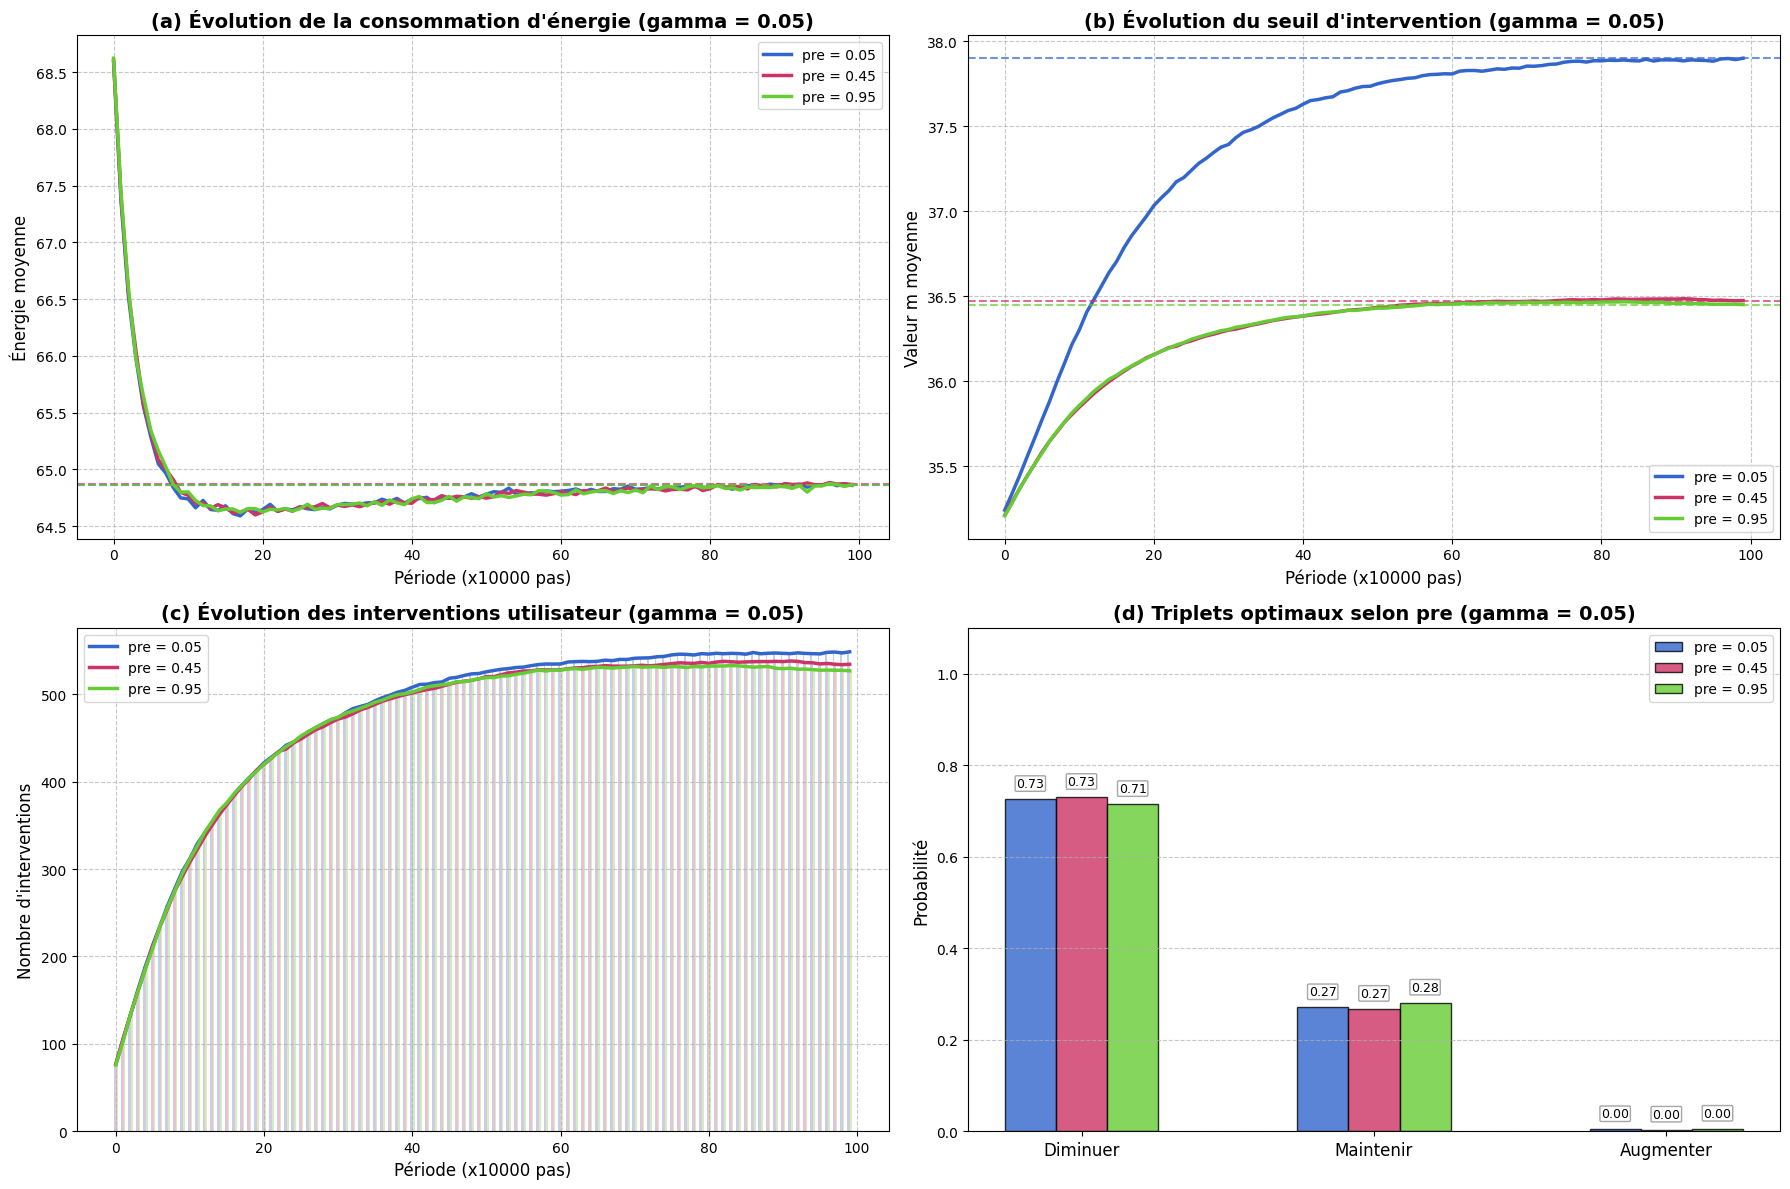

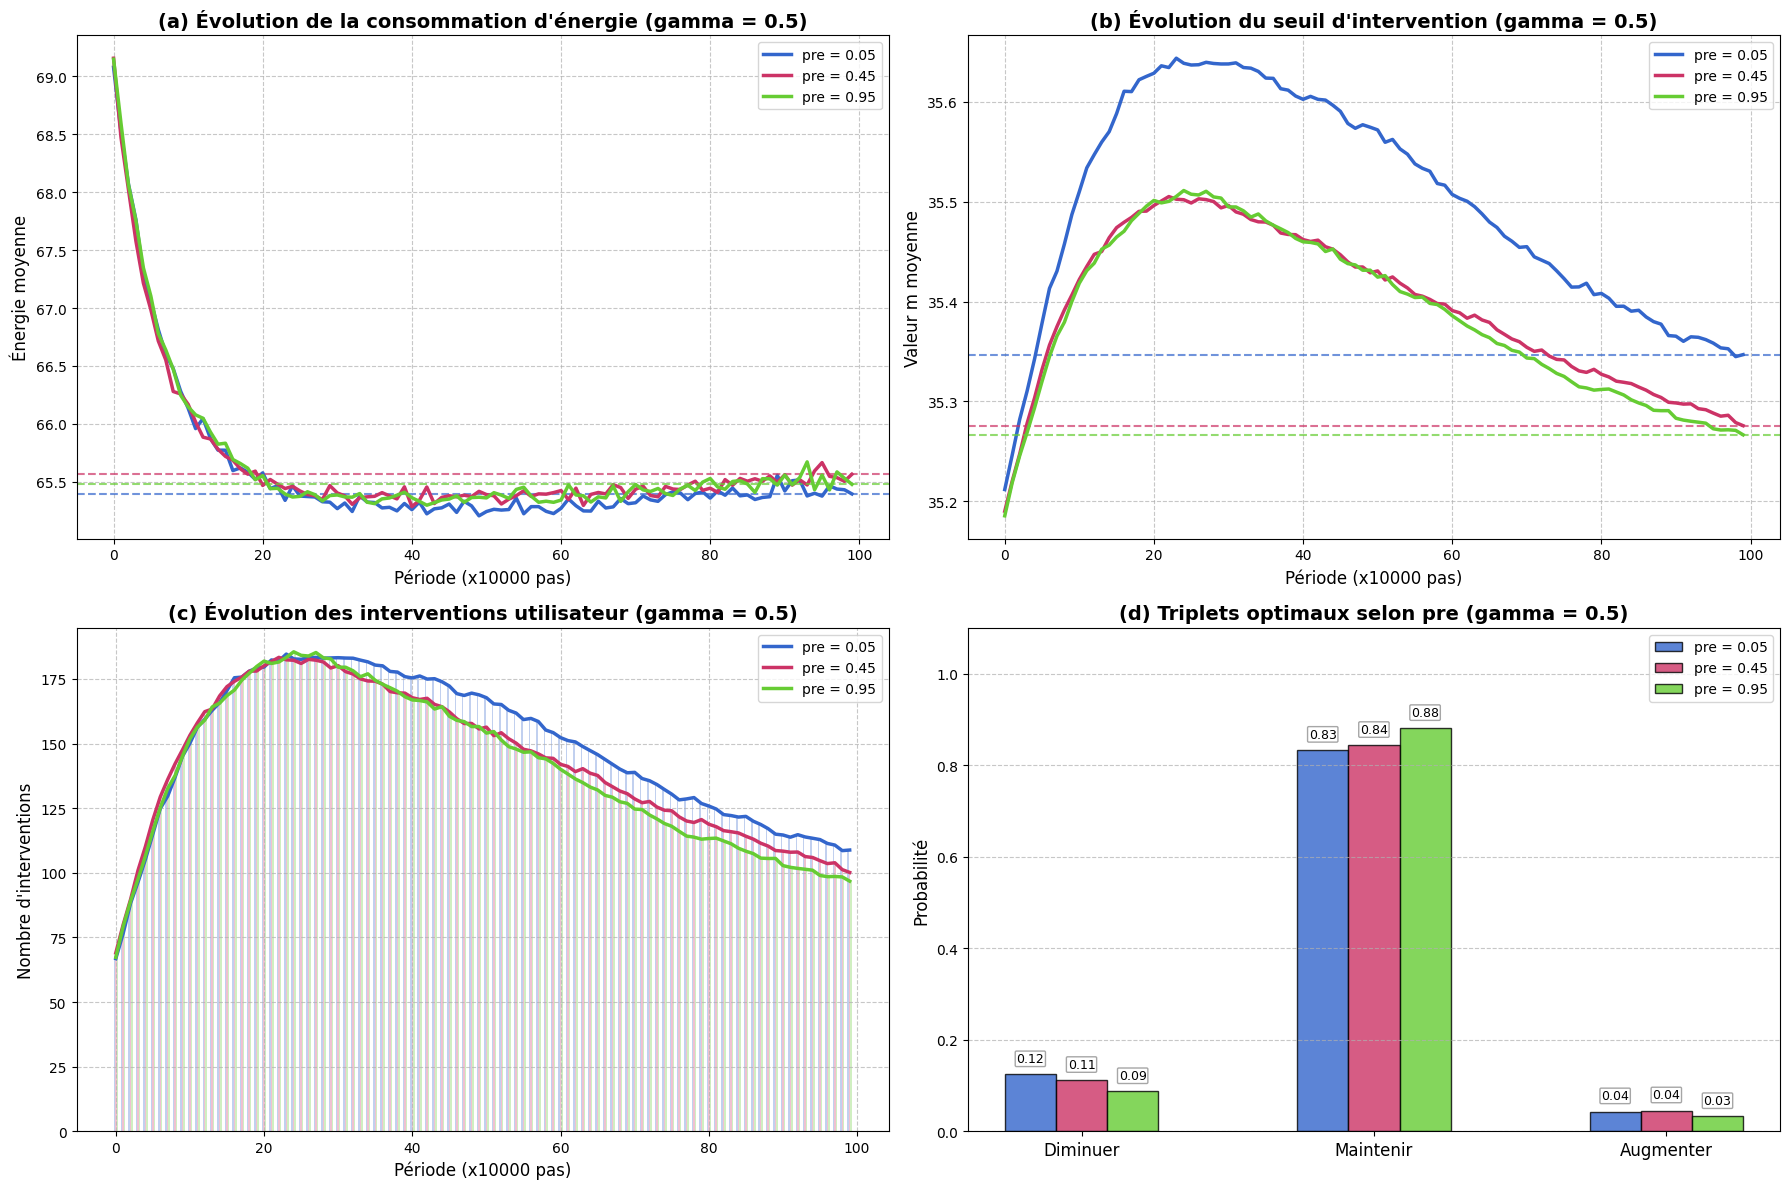

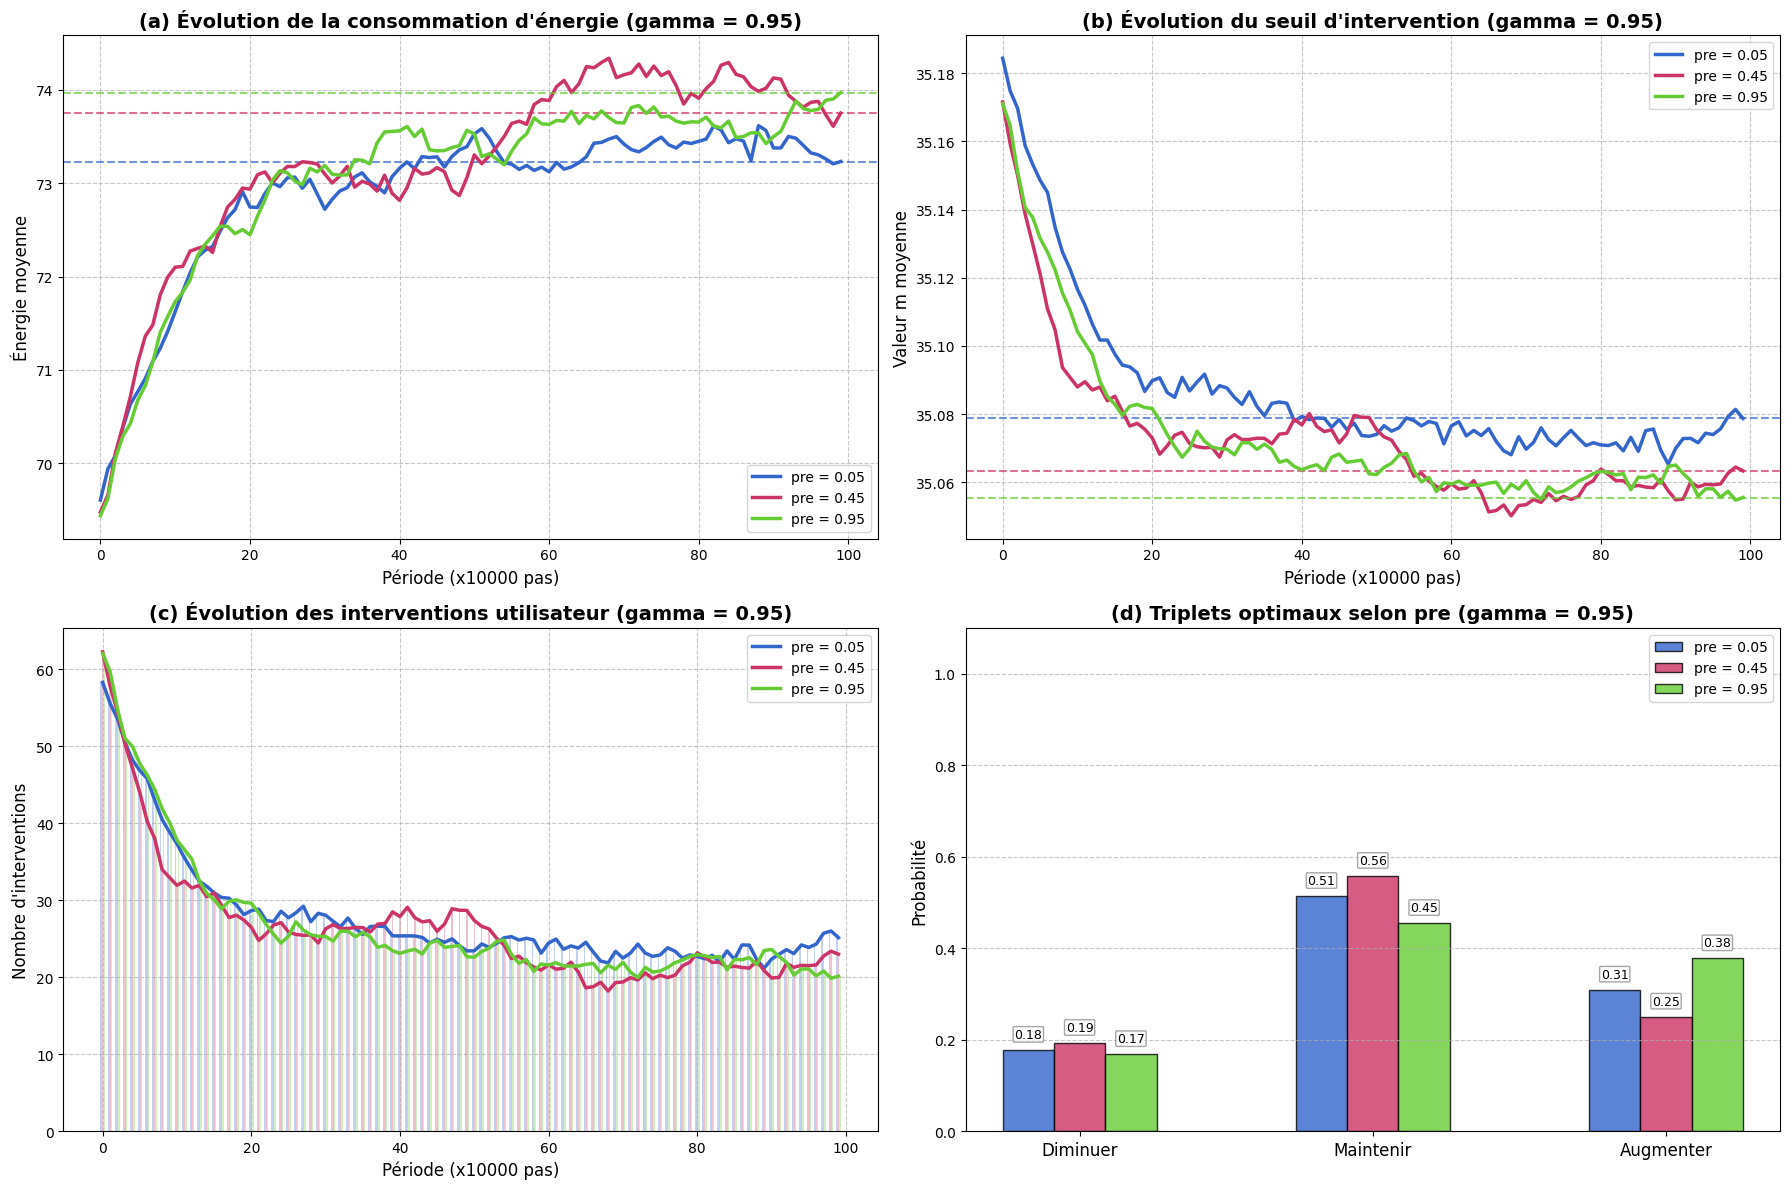


Résultats finaux:

Gamma = 0.05:
  pre = 0.05:
    Triplet optimal: [0.73, 0.27, 0.00]
    Énergie finale: 64.86
    Seuil m final: 37.90
  pre = 0.45:
    Triplet optimal: [0.73, 0.27, 0.00]
    Énergie finale: 64.87
    Seuil m final: 36.48
  pre = 0.95:
    Triplet optimal: [0.71, 0.28, 0.00]
    Énergie finale: 64.86
    Seuil m final: 36.45

Gamma = 0.5:
  pre = 0.05:
    Triplet optimal: [0.12, 0.83, 0.04]
    Énergie finale: 65.40
    Seuil m final: 35.35
  pre = 0.45:
    Triplet optimal: [0.11, 0.84, 0.04]
    Énergie finale: 65.56
    Seuil m final: 35.28
  pre = 0.95:
    Triplet optimal: [0.09, 0.88, 0.03]
    Énergie finale: 65.48
    Seuil m final: 35.27

Gamma = 0.95:
  pre = 0.05:
    Triplet optimal: [0.18, 0.51, 0.31]
    Énergie finale: 73.23
    Seuil m final: 35.08
  pre = 0.45:
    Triplet optimal: [0.19, 0.56, 0.25]
    Énergie finale: 73.75
    Seuil m final: 35.06
  pre = 0.95:
    Triplet optimal: [0.17, 0.45, 0.38]
    Énergie finale: 73.97
    Seuil m final

{0.05: {0.05: {'energy': array([68.5934325, 67.3625025, 66.5182725, 65.97919  , 65.55621  ,
          65.284035 , 65.048375 , 64.9666825, 64.8402875, 64.7481475,
          64.73949  , 64.6611   , 64.7260725, 64.645995 , 64.6384275,
          64.6788   , 64.61005  , 64.5901025, 64.6515575, 64.619475 ,
          64.6453   , 64.6914475, 64.62975  , 64.6512675, 64.6423825,
          64.6694625, 64.6523775, 64.6445925, 64.662295 , 64.651225 ,
          64.684915 , 64.699295 , 64.6932575, 64.6941375, 64.704285 ,
          64.7055475, 64.7364025, 64.71542  , 64.743605 , 64.70187  ,
          64.73759  , 64.7426225, 64.7531575, 64.7060375, 64.7484025,
          64.7446125, 64.7490025, 64.7564725, 64.7848175, 64.7567225,
          64.78094  , 64.8026275, 64.7970275, 64.833785 , 64.7813725,
          64.78373  , 64.7930875, 64.7899   , 64.80946  , 64.8029875,
          64.807255 , 64.8138225, 64.82676  , 64.80091  , 64.8233975,
          64.80463  , 64.8049175, 64.828895 , 64.82475  , 64.8523275

In [35]:
experiment_4(n_steps=1000000, granularity=0.05, alpha=0.0005, 
                            pre_values=[0.05, 0.45, 0.95], gamma_values=[0.05, 0.5, 0.95], 
                            period_length=10000, n_runs=100)